In [16]:
# Notebook developed to study the image sensitivity to variations in the 10 control parameters associated 
# with M2 and CAM.
#
# This notebook is based on an original notebook provide by Bo Xin.
# See: https://github.com/bxin/IM/blob/master/tutorials/IQvsZernikes_2D.ipynb
#
# Jun Yin, January 2019.

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lsst.cwfs.tools import ZernikeEval, ZernikeGrad
import matplotlib.colors as colors
from decimal import Decimal
mpl.rc('image', cmap='jet')

In [17]:
#set up the pupil
# Vary x and y between -1 and +1 with 201 steps.
x1d = np.linspace(-1,1,201)

# Create a grid, evenly spaced points.
x, y = np.meshgrid(x1d, x1d)
r = np.sqrt(x**2 + y**2)

# Points for which r > 1 are not considered (they are outside the bounday).
# Set those points to NAN so that they are not being processed in the rest of the code.
idx = r>1
x[idx] = np.nan
y[idx] = np.nan
r[idx] = np.nan

In [18]:
# Define which CP to change and define the 10 values considered.
# NOTE: this is the only section in the code that needs to be modified.
# After changng a number here, select "Run All" from the Cell menu.

# Define the CPs to use.

# Define maximum value of CP.
maxCP = 100.

# Define the number of the control paramter (value between 1 and 10)
numberCP = 10

# Define the array with values of CP
CP = np.linspace(10.,maxCP,10)


In [19]:
def GetZernikes(CP,numberCP):
    
    # Function to determine the Zernike coefficients for different control paramters (CPs).
    # CP = value of control parameter (in um)
    # numberCp = number of control parameter.
    # Note: we only consider one control parameter at a time and assume that all other ones are 0.
    
    # Define DOF array.
    DOF = [0,0,0,0,0,0,0,0,0,0]
    Field = 32
    DOF[numberCP-1] = CP

    # Read the text file with the perturbation coefficients of interest.
    # The function loadtxt reads the input file, skips all lines that start with a #,
    # and creates a 2D numpy array.  The number of rows is equal to the number of
    # lines in the file and the number of columns is defined by the number of values
    # read on each line.  The default assumes that floats are being read.
    dataRead = np.loadtxt('./ZvsCP/senM_35_19_50.txt',comments="#")

    # The file read contains data for 35 field positions.  For each field position,
    # 19 Zernike values are provided (Z4 - Z22), for 10 rigid body perturbations and
    # 40 mirror bending modes.  There is one line for each field position/Zernike term.
    # The array read is thus a (25x19) x 50 = 665 x 50 array.  Verify this.
    dataRead.shape

    # Now we need to reshape the array from 2D to 3D.
    dataRead = dataRead.reshape(35,19,50)

    # Verify that is actually worked.
    dataRead.shape

    # Define the Zernike array.  There are 19 Zernike terms, starting at Z4.
    Zs = np.zeros(19)

    # Calculate the Zernike amplitudes.

    # Loop over Zernike terms.
    for i in range(0,len(Zs)):

        # Set the value of the Zernike term to 0
        Zs[i] = 0.0
   
        # Loop over the DOFs
        for j in range(0,len(DOF)):

            # Add the contribution of the current DOF to the Zernike term.
            Zs[i] = Zs[i] + DOF[j]*dataRead[Field-1,i,j]

        # Completed the loops to determine the Zernike coeffiecients.
        
    # We now have determined the proper values of the Zernike coefficients.

    # Return the Zernike amplitudes
    # The Zernike amplitudes are in units of um.
    return Zs

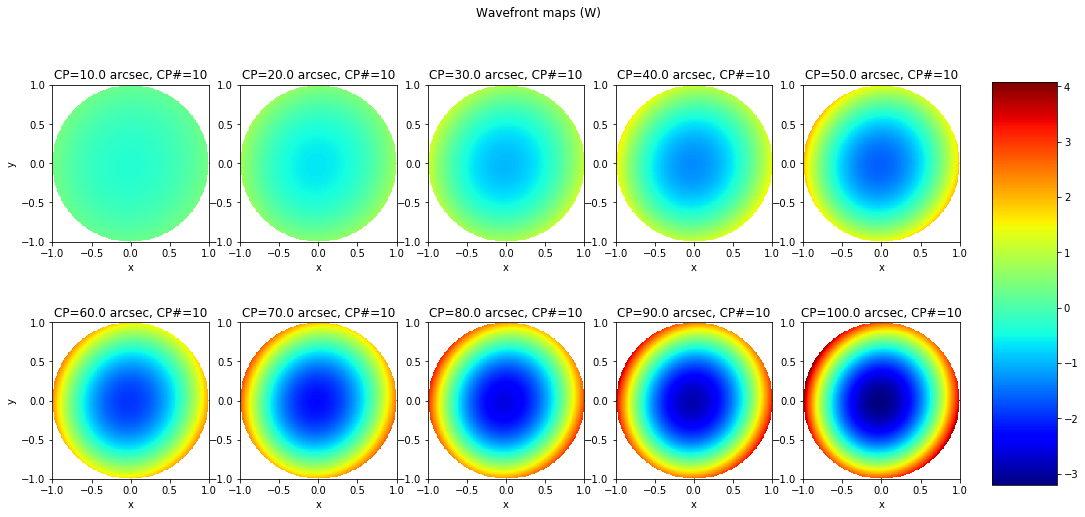

In [29]:
# Start with creating the wavefront.

# Define the Zernikes for these CPs.
ZCoef = [GetZernikes(i,numberCP) for i in CP]

# Define the arrays that contain the Zernike coefficients.
# Note: the CPs will only define the Zernike coefficients, start at Z4.
# The paper from Angeli et. al. states that: 
#     "the first 3 terms (piston/tip/tilt) are omitted"
# Thus Z1 = Z2 = Z3 = 0.  We need to keep in mind that Z1 = zc[:,0].
zc = np.zeros([10, 22])

# Fill the non-zero values of zc
for index in range(3,22):
    zc[:,index] = [ZCoef[i][index-3] for i in range(0,len(CP))]

# Define the wavefront and set it to 0.
w = np.zeros([10,201,201])

# Calculate the wavefront across the pupil.
for i in range(10):
    w[i,:,:] = ZernikeEval(zc[i,:], x, y)
    
# Create a figure with 10 subplots, arranged in a 2 x 5 configuration.    
fig, ax = plt.subplots(2,5, figsize = (18,8))

# The maximum and minimum scales are defined by the image that has the largest CP.
wmin = np.nanmin(w[9,:,:])
wmax = np.nanmax(w[9,:,:])

for i in range(10):
    irow = np.int8(i/5)
    icol = np.mod(i,5)
    #print(irow, icol)
    
    img = ax[irow][icol].imshow(w[i,:,:], vmin=wmin, vmax=wmax,extent=[min(x1d), max(x1d), min(x1d), max(x1d)])
    if ((numberCP==4) or (numberCP==5) or (numberCP==9) or (numberCP==10)):
        ax[irow][icol].set_title('CP=%.1f arcsec, CP#=%.0f'%(CP[i], numberCP))
    else:
        ax[irow][icol].set_title('CP=%.1f um, CP#=%.0f'%(CP[i], numberCP))
    ax[irow][icol].set_xlabel('x')
    if (icol==0): ax[irow][icol].set_ylabel('y')

# Adjust position of subplots to allow a single color bar.
fig.subplots_adjust(right=0.825)

# Add single color bar.
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax)
    
fig.suptitle('Wavefront maps (W)')

# Create filename for figure.
fileName = './Images/WaveFront_CP%.0f'%(numberCP)

# Save figure to file.
fig.savefig(fileName)

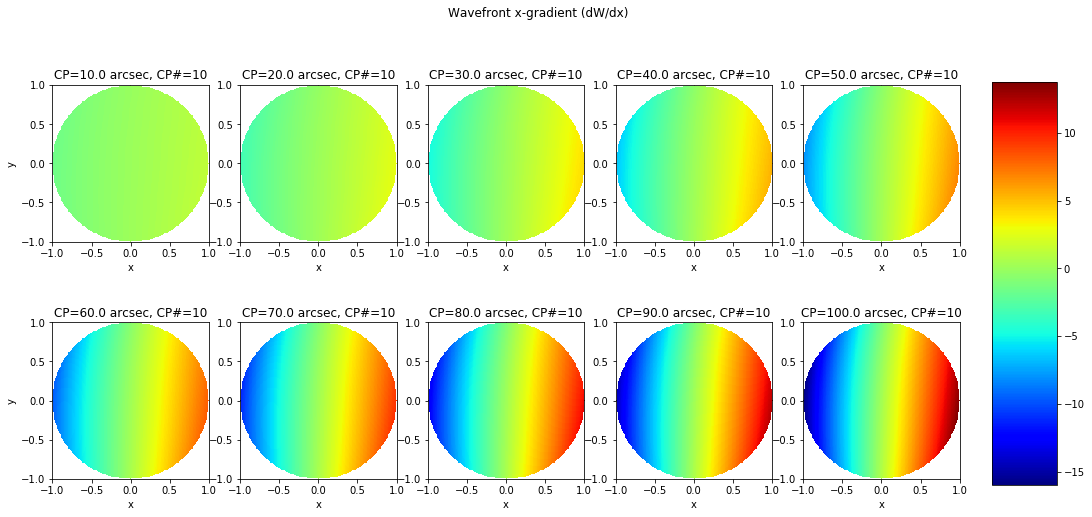

In [21]:
# Calculate dw/dx and dw/dy
dwdx = np.zeros([10,201,201])
dwdy = np.zeros([10,201,201])

for i in range(10):
    dwdx[i,:,:] = ZernikeGrad(zc[i,:], x, y, 'dx')
    dwdy[i,:,:] = ZernikeGrad(zc[i,:], x, y, 'dy')
fig, ax = plt.subplots(2,5, figsize = (18,8))

# The maximum and minimum scales are defined by the image that has the largest CP.
dwdxmin = np.nanmin(dwdx[9,:,:])
dwdxmax = np.nanmax(dwdx[9,:,:])

for i in range(10):
    irow = np.int8(i/5)
    icol = np.mod(i,5)

    # Create gradient plots.
    img = ax[irow][icol].imshow(dwdx[i,:,:], vmin=dwdxmin, vmax=dwdxmax, extent=[min(x1d), max(x1d), min(x1d), max(x1d)])
    if ((numberCP==4) or (numberCP==5) or (numberCP==9) or (numberCP==10)):
        ax[irow][icol].set_title('CP=%.1f arcsec, CP#=%.0f'%(CP[i], numberCP))
    else:
        ax[irow][icol].set_title('CP=%.1f um, CP#=%.0f'%(CP[i], numberCP))
    ax[irow][icol].set_xlabel('x')
    if (icol==0): ax[irow][icol].set_ylabel('y')
    
# Adjust position of subplots to allow a single color bar.
fig.subplots_adjust(right=0.825)

# Add single color bar.
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax)
    
fig.suptitle('Wavefront x-gradient (dW/dx)')

# Create filename for figure.
fileName = './Images/dWdx_CP%.0f'%(numberCP)

# Save figure to file.
fig.savefig(fileName)

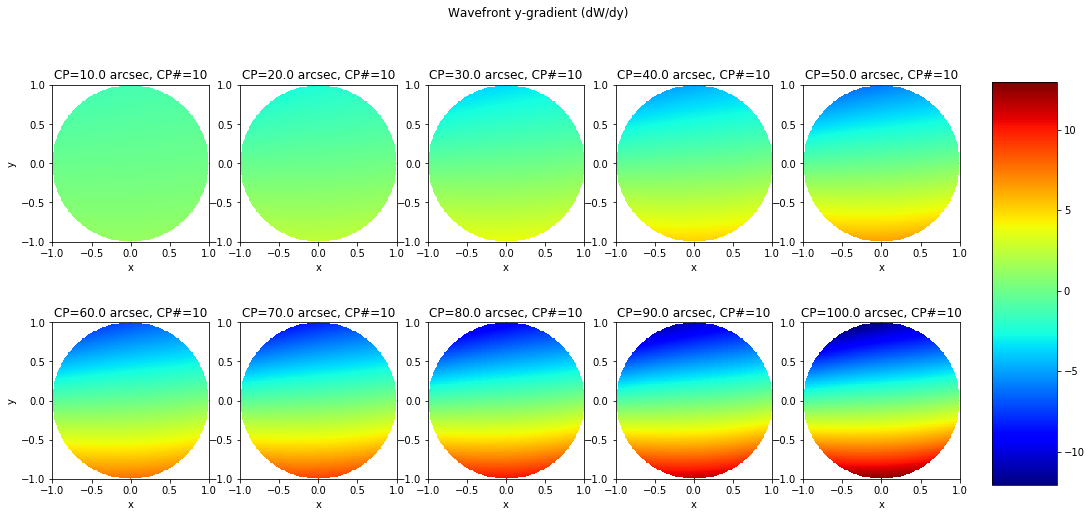

In [22]:
# Show the y gradient of the wavefornt.
fig, ax = plt.subplots(2,5, figsize = (18,8))

# The maximum and minimum scales are defined by the image that has the largest CP.
dwdymin = np.nanmin(dwdy[9,:,:])
dwdymax = np.nanmax(dwdy[9,:,:])

for i in range(10):
    irow = np.int8(i/5)
    icol = np.mod(i,5)
    
    # Create gradient plots.
    img = ax[irow][icol].imshow(dwdy[i,:,:], vmin=dwdymin, vmax=dwdymax, extent=[min(x1d), max(x1d), min(x1d), max(x1d)])
    if ((numberCP==4) or (numberCP==5) or (numberCP==9) or (numberCP==10)):
        ax[irow][icol].set_title('CP=%.1f arcsec, CP#=%.0f'%(CP[i], numberCP))
    else:
        ax[irow][icol].set_title('CP=%.1f um, CP#=%.0f'%(CP[i], numberCP))
    ax[irow][icol].set_xlabel('x')
    if (icol==0): ax[irow][icol].set_ylabel('y')

# Adjust position of subplots to allow a single color bar.
fig.subplots_adjust(right=0.825)

# Add single color bar.
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax)
    
fig.suptitle('Wavefront y-gradient (dW/dy)')

# Create filename for figure.
fileName = './Images/dWdy_CP%.0f'%(numberCP)

# Save figure to file.
fig.savefig(fileName)

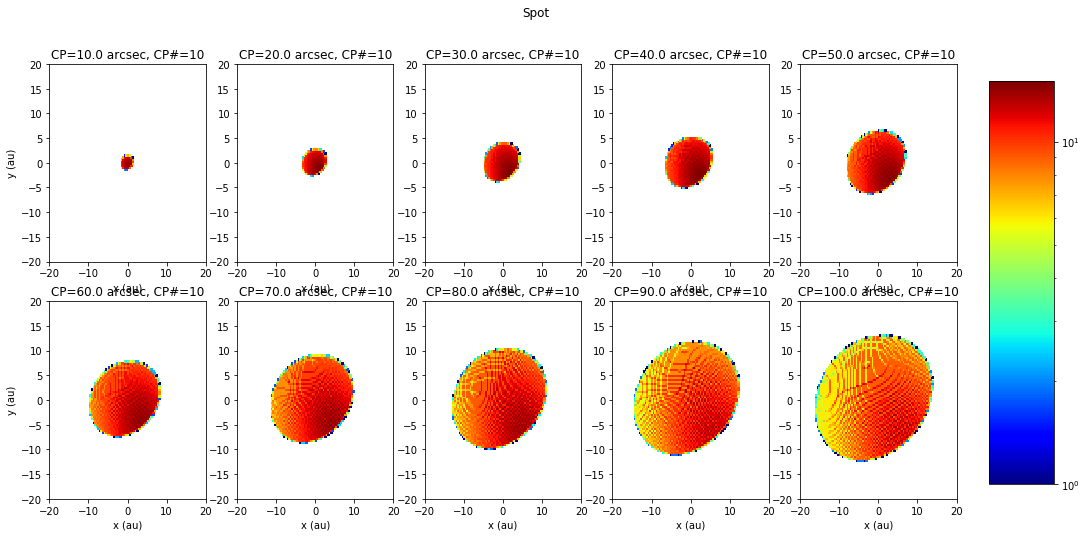

In [23]:
# Calculate the RMS spot size for the 10 different settings.

# Create arrya to hold the results of these calculations.
rmsSpotSize = np.zeros(10)

fig, ax = plt.subplots(2,5, figsize = (18,8))

for i in range(10):
    irow = np.int8(i/5)
    icol = np.mod(i,5)
    
    # Get the gradients.
    xr = dwdx[i,:,:].reshape(-1,1)
    yr = dwdy[i,:,:].reshape(-1,1)

    # Identify the points that are not on the pupil and set their gradients to nan.
    idx = ~np.isnan(xr)
    xr = xr[idx]
    yr = yr[idx]
    
    # Calculate the rms spot size.  Note: the units are arbitrary.
    rmsSpotSize[i] = np.sqrt(np.sum(xr**2 + yr**2))
    counts, xedges, yedges, img = ax[irow][icol].hist2d(xr, yr, bins=100, norm=colors.LogNorm(), range=[[-20, 20], [-20, 20]])
    if ((numberCP==4) or (numberCP==5) or (numberCP==9) or (numberCP==10)):
        ax[irow][icol].set_title('CP=%.1f arcsec, CP#=%.0f'%(CP[i], numberCP))
    else:
        ax[irow][icol].set_title('CP=%.1f um, CP#=%.0f'%(CP[i], numberCP))
    ax[irow][icol].set_xlabel('x (au)')
    if (icol==0): ax[irow][icol].set_ylabel('y (au)')

# Adjust position of subplots to allow a single color bar.
fig.subplots_adjust(right=0.825)

# Add single color bar.
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax)

fig.suptitle('Spot')

# Create filename for figure.
fileName = './Images/ImageSpot_CP%.0f'%(numberCP)

# Save figure to file.
fig.savefig(fileName)

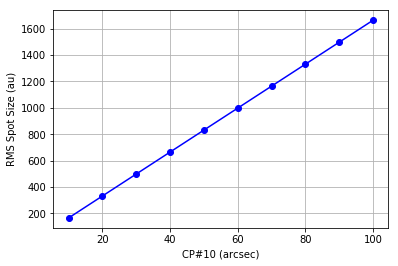

In [24]:
plt.plot(CP,rmsSpotSize,'-bo')
plt.grid()
if ((numberCP==4) or (numberCP==5) or (numberCP==9) or (numberCP==10)):
    plt.xlabel('CP#%.0f (arcsec)'%(numberCP))
else:
    plt.xlabel('CP#%.0f (um)'%(numberCP))
plt.ylabel('RMS Spot Size (au)')

# Create filename for figure.
fileName = './Images/RMSVsCP_CP%.0f'%(numberCP)

# Save figure to file.
plt.savefig(fileName)

/Users/junyin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in arccos
  from ipykernel import kernelapp as app


The 80 percent opening angle is 0.4 urad when CP = 28.1 um


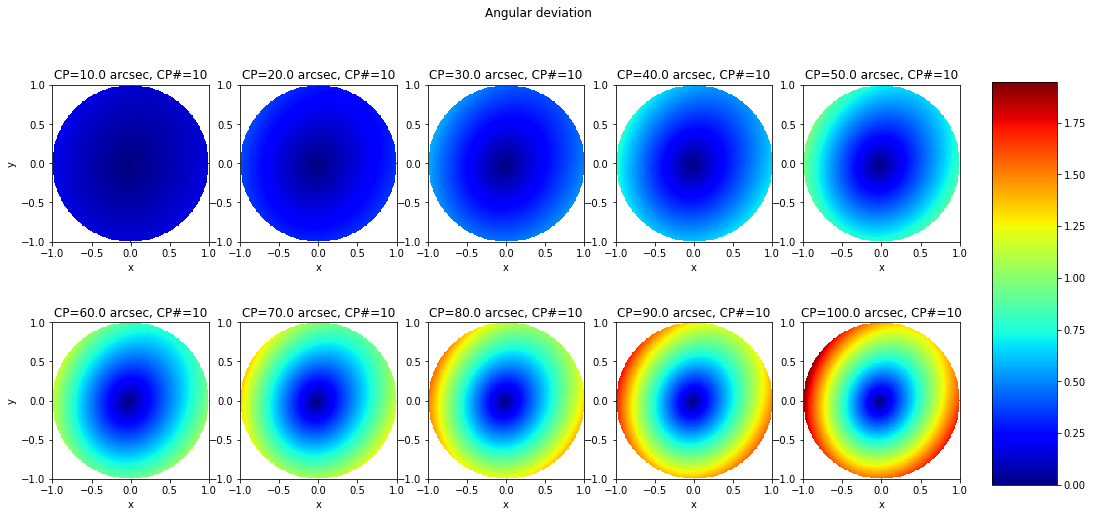

In [25]:
# Calculate the opening angle between the actual ray and the perfect ray. 
# The opening angle is defined as the angle that captures 80% of all rays.
thetaCone = np.zeros(10)

# Create the figure (fig) and subplots (ax)
fig, ax = plt.subplots(2,5, figsize = (18,8))

# Define the opening angle distribution.
# Give it the same shape as the wavefront array.
thetaDist = w

# Calculate the opening angle as function of position across the pupil for each CP value.
# See the comment in the loop below for the explanation of the scale factor 1.2E-7.
for i in range(10):
    thetaDist[i,:,:] = 1.0E6*np.arccos(1./np.sqrt((dwdx[i,:,:]*1.2E-7)**2+(dwdy[i,:,:]*1.2E-7)**2+1.))

# The maximum and minimum scales are defined by the image that has the largest CP.
thetaDistMin = np.nanmin(thetaDist[9,:,:])
thetaDistMax = np.nanmax(thetaDist[9,:,:])

# Loop over all possible CP values.
for i in range(10):
    irow = np.int8(i/5)
    icol = np.mod(i,5)
    xr = dwdx[i,:,:].reshape(-1,1)
    yr = dwdy[i,:,:].reshape(-1,1)
    idx = ~np.isnan(xr)
    xr = xr[idx]
    yr = yr[idx]
    
    # Note: the Zernikes are defined on a unit circle.  x and y thus vary between -1 and +1.
    # For LSST, the primary mirror is 8.4 m.
    # The amplitudes of the Zernikes are in units of um.
    # Thus dw/dx should be scaled by 1E-6/8.4 = 1.2E-7
    # The following calculation is in principle correct, but for small values of xr, the limited precision
    # results in the angle being evaluated to 0.
    theta = np.arccos(1./np.sqrt((xr*1.2E-7)**2+(yr*1.2E-7)**2+1.))
    # Instead, we calculate sin(theta) and the use the approximation that sin(theta) = theta for small angles
    theta = np.sqrt((xr*1.2E-7)**2+(yr*1.2E-7)**2)/np.sqrt((xr*1.2E-7)**2+(yr*1.2E-7)**2+1.)

    # To find the 80% angle, we sort the array and then find the angle at 80% of the array length.
    # This value is stored in the thetaCone array.
    theta_sorted=sorted(theta)
    thetaCone[i] = theta_sorted[int(.8*len(theta_sorted))]

    # Create the plots.
    img = ax[irow][icol].imshow(thetaDist[i,:,:], vmin=thetaDistMin, vmax=thetaDistMax, extent=[min(x1d), max(x1d), min(x1d), max(x1d)])
    if ((numberCP==4) or (numberCP==5) or (numberCP==9) or (numberCP==10)):
        ax[irow][icol].set_title('CP=%.1f arcsec, CP#=%.0f'%(CP[i], numberCP))
    else:
        ax[irow][icol].set_title('CP=%.1f um, CP#=%.0f'%(CP[i], numberCP))
    ax[irow][icol].set_xlabel('x')
    if (icol==0): ax[irow][icol].set_ylabel('y')

# Adjust position of subplots to allow a single color bar.
fig.subplots_adjust(right=0.825)

# Add single color bar.
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax)

fig.suptitle('Angular deviation')

# Calculate the slope of the observed correlation between opening angle and DOF.
slope,offset=np.polyfit(CP,1E6*thetaCone,1)

# Use the slope to determine the CP value for which the opening angle is 0.4 urad.
dCP = 0.4/slope

print ('The 80 percent opening angle is 0.4 urad when CP = %.1f um'%(dCP))

# Create filename for figure.
fileName = './Images/AngularDeviation_CP%.0f'%(numberCP)

# Save figure to file.
fig.savefig(fileName)

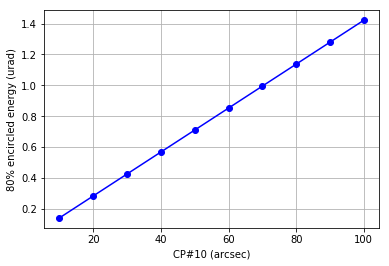

In [26]:
plt.plot(CP,1E6*thetaCone,'-bo')
plt.grid()
if ((numberCP==4) or (numberCP==5) or (numberCP==9) or (numberCP==10)):
    plt.xlabel('CP#%.0f (arcsec)'%(numberCP))
else:
    plt.xlabel('CP#%.0f (um)'%(numberCP))
plt.ylabel('80% encircled energy (urad)')

# Create filename for figure.
fileName = './Images/80PercAngleVsCP_CP%.0f'%(numberCP)

# Save figure to file.
plt.savefig(fileName)

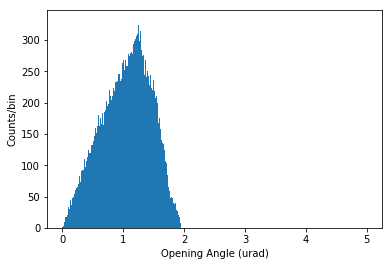

In [27]:
hist_theta_dist, bins_theta_dist = np.histogram(1E6*theta, bins = 501, range = [0.,5.])
plt.hist(1E6*theta,bins_theta_dist)
plt.xlabel('Opening Angle (urad)')
plt.ylabel('Counts/bin')

# Create filename for figure.
fileName = './Images/80PercAngleHisto_CP%.0f'%(numberCP)

# Save figure to file.
plt.savefig(fileName)

In [28]:
# Ignore all the cells below this line.  They are just show and tell.